# Data pre-processing

In [1]:
import numpy as np
import pandas as pd

from sklearn import preprocessing

In [3]:
# Load the data from the uploaded CSV file
file_path = "/content/combined_mutation_CNV.csv"
data = pd.read_csv(file_path)

# Separate the features and labels
labels = data["Subtype"].values
features = data.drop(columns=["Subtype", "Sample"]).values

# Convert to numpy arrays
labels = np.array(labels)
labels[labels=='PDM'] = 0
labels[labels=='SCM'] = 1

features = np.array(features)

# Output the results
print("Labels:", labels.shape)
print("Features:", features.shape)


Labels: (43,)
Features: (43, 656)


In [4]:
# Create a MinMaxScaler object with a feature range of -1 to 1
min_max_Scalar = preprocessing.MinMaxScaler(feature_range=(-1, 1))

# Fit the MinMaxScaler to the data (excluding the last column) and transform the data
# This scales the features to the specified range (-1 to 1)
features = min_max_Scalar.fit_transform(features)

# Convert the transformed data to a NumPy array
features = np.asarray(features)

# PCA

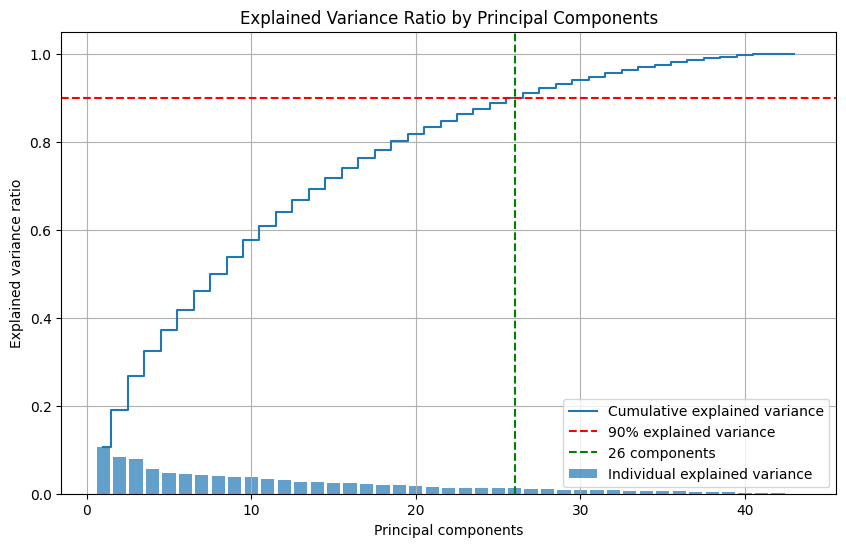

Number of components needed to explain 90% of the variance: 26


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# Apply PCA
pca = PCA()
principal_components = pca.fit_transform(features)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Find the number of components needed to explain 90% variance
n_components_90 = np.argmax(cumulative_explained_variance >= 0.90) + 1

# Plot explained variance ratio and cumulative explained variance
plt.figure(figsize=(10, 6))
plt.bar(
    range(1, len(explained_variance_ratio) + 1),
    explained_variance_ratio,
    alpha=0.7,
    align="center",
    label="Individual explained variance",
)
plt.step(
    range(1, len(cumulative_explained_variance) + 1),
    cumulative_explained_variance,
    where="mid",
    label="Cumulative explained variance",
)
plt.axhline(y=0.90, color="r", linestyle="--", label="90% explained variance")
plt.axvline(
    x=n_components_90, color="g", linestyle="--", label=f"{n_components_90} components"
)

plt.ylabel("Explained variance ratio")
plt.xlabel("Principal components")
plt.legend(loc="best")
plt.title("Explained Variance Ratio by Principal Components")
plt.grid()
plt.show()

# Print the number of components needed to explain 90% of the variance
print(f"Number of components needed to explain 90% of the variance: {n_components_90}")


In [6]:
# Apply PCA
pca = PCA(n_components=26)
new_features = pca.fit_transform(features)

new_features.shape


(43, 26)

# Helper Functions

In [7]:
import json

import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder

In [8]:
def encode_labels(labels):
    """Encode labels if they are not integers."""
    label_encoder = LabelEncoder()
    return label_encoder.fit_transform(labels)

def perform_k_fold_cv(features, labels_encoded, best_params, model):
    """Perform k-fold cross-validation with the best parameters and return results."""
    skf = StratifiedKFold(n_splits=5)
    accuracies = []
    all_classification_reports = []
    all_confusion_matrices = []

    for train_index, test_index in skf.split(features, labels_encoded):
        x_train_fold, x_test_fold = features[train_index], features[test_index]
        y_train_fold, y_test_fold = (
            labels_encoded[train_index],
            labels_encoded[test_index],
        )

        model_fold = model(**best_params)
        model_fold.fit(x_train_fold, y_train_fold)

        y_pred_fold = model_fold.predict(x_test_fold)
        accuracy_fold = metrics.accuracy_score(y_test_fold, y_pred_fold) * 100
        accuracies.append(accuracy_fold)

        classification_report_fold = classification_report(
            y_test_fold, y_pred_fold, output_dict=True
        )
        all_classification_reports.append(classification_report_fold)

        confusion_matrix_fold = confusion_matrix(y_test_fold, y_pred_fold)
        all_confusion_matrices.append(confusion_matrix_fold)

    return accuracies, all_classification_reports, all_confusion_matrices


def compute_average_classification_report(all_classification_reports):
    """Compute the average classification report."""
    return {
        key: {
            "precision": np.mean(
                [cr[key]["precision"] for cr in all_classification_reports]
            ),
            "recall": np.mean([cr[key]["recall"] for cr in all_classification_reports]),
            "f1-score": np.mean(
                [cr[key]["f1-score"] for cr in all_classification_reports]
            ),
            "support": np.mean(
                [cr[key]["support"] for cr in all_classification_reports]
            ),
        }
        for key in all_classification_reports[0].keys()
        if key != "accuracy"
    }


def plot_average_classification_report(average_classification_report):
    """Plot the average classification report."""
    categories = list(average_classification_report.keys())
    precision = [average_classification_report[cat]["precision"] for cat in categories]
    recall = [average_classification_report[cat]["recall"] for cat in categories]
    f1_score = [average_classification_report[cat]["f1-score"] for cat in categories]

    x = np.arange(len(categories))  # the label locations
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width, precision, width, label="Precision")
    rects2 = ax.bar(x, recall, width, label="Recall")
    rects3 = ax.bar(x + width, f1_score, width, label="F1-Score")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel("Scores")
    ax.set_title("Average Classification Report by Category")
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45)
    ax.legend()

    fig.tight_layout()
    plt.show()


def plot_average_confusion_matrix(all_confusion_matrices):
    """Plot the average confusion matrix."""
    average_confusion_matrix = np.mean(all_confusion_matrices, axis=0)
    disp = ConfusionMatrixDisplay(confusion_matrix=average_confusion_matrix.astype(int))
    disp.plot()
    plt.show()


def main(features, labels, param_grid, model):
    # Encode labels if necessary
    labels_encoded = encode_labels(labels)

    # Perform Grid Search to find the best parameters
    grid_search = GridSearchCV(
        model(), param_grid, cv=StratifiedKFold(n_splits=5), scoring="accuracy"
    )
    grid_search.fit(features, labels_encoded)
    best_params = grid_search.best_params_

    print("Best parameters found by GridSearchCV: ", best_params)

    # Perform k-fold cross-validation
    accuracies, all_classification_reports, all_confusion_matrices = perform_k_fold_cv(
        features, labels_encoded, best_params, model
    )

    # Print average accuracy
    mean_accuracy = np.mean(accuracies)
    print("Mean accuracy over all folds: {:.2f}%".format(mean_accuracy))

    # Compute and print average classification report
    average_classification_report = compute_average_classification_report(
        all_classification_reports
    )
    print(
        "Average Classification Report:\n",
        json.dumps(average_classification_report, indent=4),
    )

    # Plot average confusion matrix
    plot_average_confusion_matrix(all_confusion_matrices)

    # Plot average classification report
    plot_average_classification_report(average_classification_report)

    return mean_accuracy

# Support Vector Machines (SVM)

In [ ]:
import warnings

from sklearn.svm import SVC


Best parameters found by GridSearchCV:  {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Mean accuracy over all folds: 62.50%
Average Classification Report:
 {
    "0": {
        "precision": 0.5933333333333333,
        "recall": 0.6,
        "f1-score": 0.580952380952381,
        "support": 4.0
    },
    "1": {
        "precision": 0.67,
        "recall": 0.6599999999999999,
        "f1-score": 0.6533333333333333,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.6316666666666667,
        "recall": 0.6300000000000001,
        "f1-score": 0.6171428571428572,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.6366666666666666,
        "recall": 0.625,
        "f1-score": 0.6171428571428572,
        "support": 8.6
    }
}


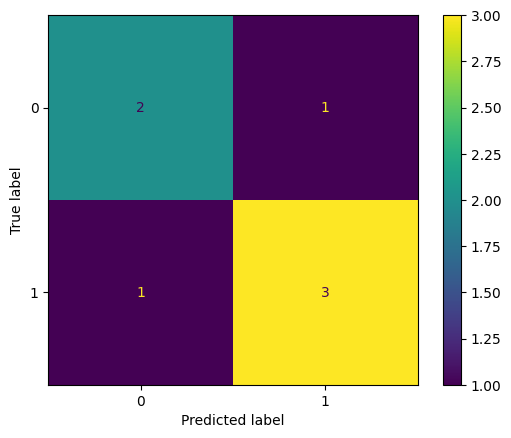

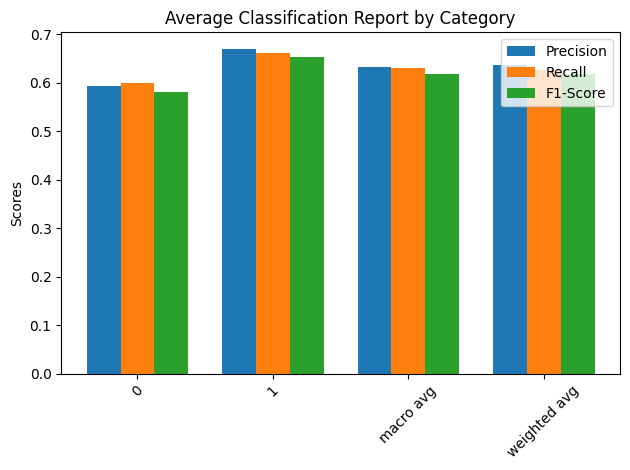

In [ ]:
# Suppress all warnings
warnings.filterwarnings("ignore")

param_grid = {
    "C": [0.1, 1, 10, 100],
    "kernel": ["linear", "rbf", "poly"],
    "gamma": ["scale", "auto"],
}

main(new_features, labels, param_grid, SVC)


# k-Nearest Neighbors (k-NN)

In [ ]:
import warnings

from sklearn.neighbors import KNeighborsClassifier

Best parameters found by GridSearchCV:  {'n_neighbors': 2}
Mean accuracy over all folds: 66.67%
Average Classification Report:
 {
    "0": {
        "precision": 0.6266666666666666,
        "recall": 0.85,
        "f1-score": 0.7066089466089467,
        "support": 4.0
    },
    "1": {
        "precision": 0.72,
        "recall": 0.51,
        "f1-score": 0.5753968253968254,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.6733333333333333,
        "recall": 0.6799999999999999,
        "f1-score": 0.6410028860028859,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.684021164021164,
        "recall": 0.6666666666666666,
        "f1-score": 0.6387157287157287,
        "support": 8.6
    }
}


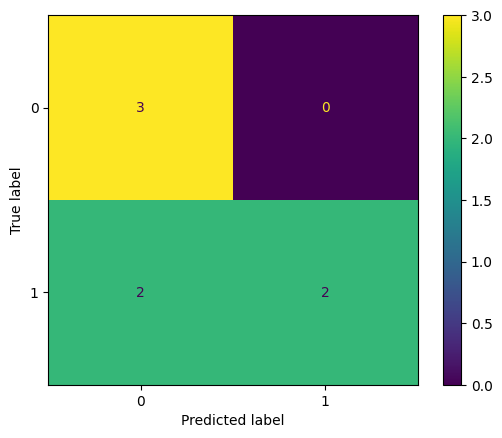

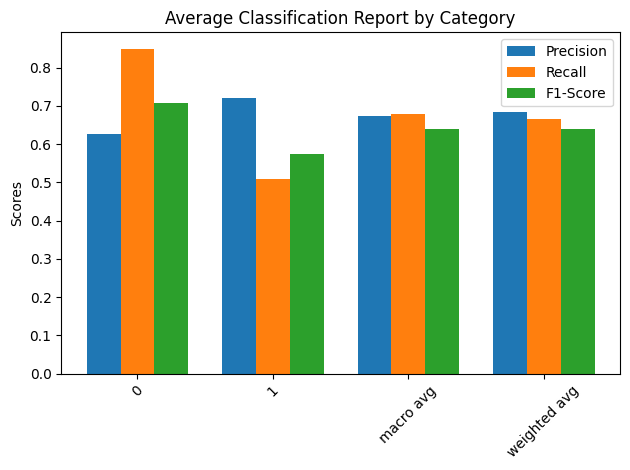

In [ ]:
# Suppress all warnings
warnings.filterwarnings("ignore")

param_grid = {"n_neighbors": np.arange(2, 10)}

main(new_features, labels, param_grid, KNeighborsClassifier)

# Logistic Regression

In [ ]:
import warnings

from sklearn.linear_model import LogisticRegression

Best parameters found by GridSearchCV:  {'C': 0.01, 'solver': 'liblinear'}
Mean accuracy over all folds: 65.00%
Average Classification Report:
 {
    "0": {
        "precision": 0.6333333333333333,
        "recall": 0.7,
        "f1-score": 0.6542857142857142,
        "support": 4.0
    },
    "1": {
        "precision": 0.6766666666666666,
        "recall": 0.6,
        "f1-score": 0.6221212121212122,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.655,
        "recall": 0.65,
        "f1-score": 0.6382034632034632,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.6574074074074073,
        "recall": 0.65,
        "f1-score": 0.6393795093795094,
        "support": 8.6
    }
}


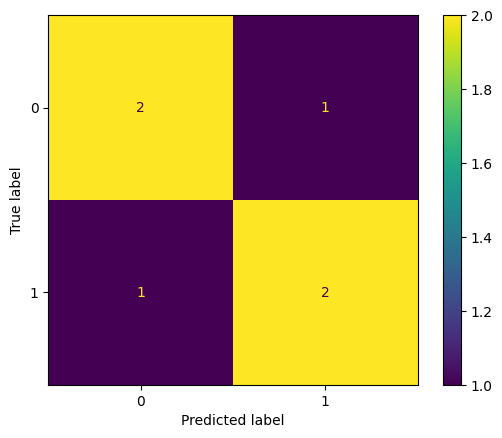

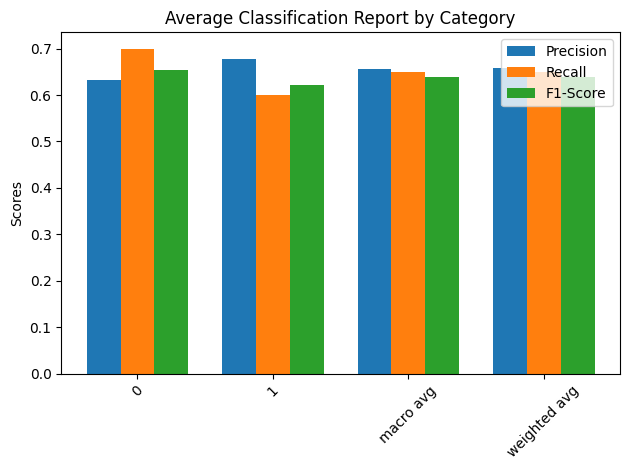

In [ ]:
# Suppress all warnings
warnings.filterwarnings("ignore")

param_grid = {"C": [0.01, 0.1, 1, 10, 100], "solver": ["lbfgs", "liblinear"]}

main(new_features, labels, param_grid, LogisticRegression)

# Decision Trees

In [ ]:
import warnings

from sklearn.tree import DecisionTreeClassifier

Best parameters found by GridSearchCV:  {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
Mean accuracy over all folds: 53.06%
Average Classification Report:
 {
    "0": {
        "precision": 0.5166666666666667,
        "recall": 0.5,
        "f1-score": 0.5014285714285713,
        "support": 4.0
    },
    "1": {
        "precision": 0.5,
        "recall": 0.55,
        "f1-score": 0.5224242424242425,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.5083333333333333,
        "recall": 0.525,
        "f1-score": 0.5119264069264069,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.5118518518518518,
        "recall": 0.5305555555555556,
        "f1-score": 0.5164790764790765,
        "support": 8.6
    }
}


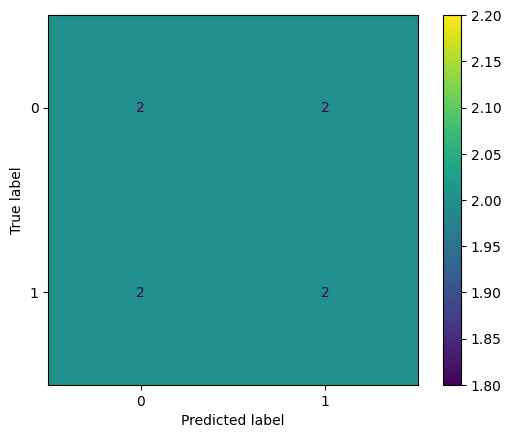

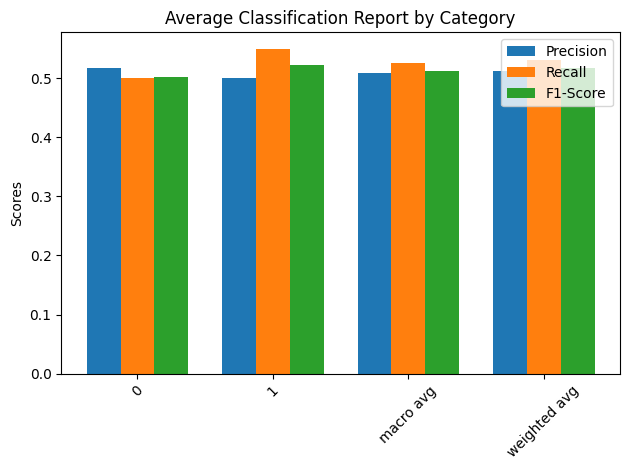

In [ ]:
# Suppress all warnings
warnings.filterwarnings("ignore")

param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 10, 20, 30, 40, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

main(new_features, labels, param_grid, DecisionTreeClassifier)

# Random Forest

In [ ]:
import warnings

from sklearn.ensemble import RandomForestClassifier

Best parameters found by GridSearchCV:  {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Mean accuracy over all folds: 62.22%
Average Classification Report:
 {
    "0": {
        "precision": 0.48,
        "recall": 0.5,
        "f1-score": 0.47777777777777775,
        "support": 4.0
    },
    "1": {
        "precision": 0.67,
        "recall": 0.75,
        "f1-score": 0.6844444444444444,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.575,
        "recall": 0.625,
        "f1-score": 0.5811111111111111,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.58,
        "recall": 0.6222222222222222,
        "f1-score": 0.5822222222222223,
        "support": 8.6
    }
}


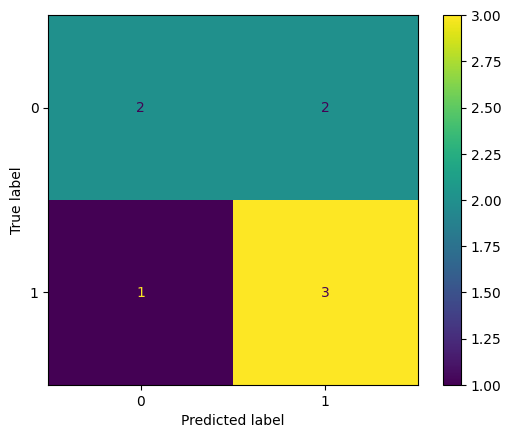

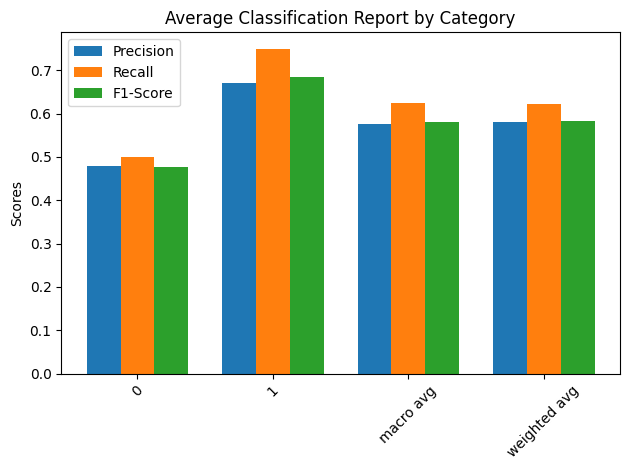

In [ ]:
# Suppress all warnings
warnings.filterwarnings("ignore")

param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}

main(new_features, labels, param_grid, RandomForestClassifier)

# XGBoost

In [ ]:
import warnings

import xgboost as xgb

In [ ]:
# Suppress all warnings
warnings.filterwarnings("ignore")

# Define the model
xgb_model = xgb.XGBClassifier
xgb_model.objective='binary:logistic'

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

main(features, labels, param_grid, xgb_model)

# All Info

In [11]:
import warnings

import xgboost as xgb

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

Best parameters found by GridSearchCV:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Mean accuracy over all folds: 66.94%
Average Classification Report:
 {
    "0": {
        "precision": 0.7033333333333334,
        "recall": 0.65,
        "f1-score": 0.6233333333333333,
        "support": 4.0
    },
    "1": {
        "precision": 0.7242857142857142,
        "recall": 0.7,
        "f1-score": 0.6887878787878788,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.7138095238095238,
        "recall": 0.675,
        "f1-score": 0.656060606060606,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.7197354497354497,
        "recall": 0.6694444444444445,
        "f1-score": 0.656060606060606,
        "support": 8.6
    }
}


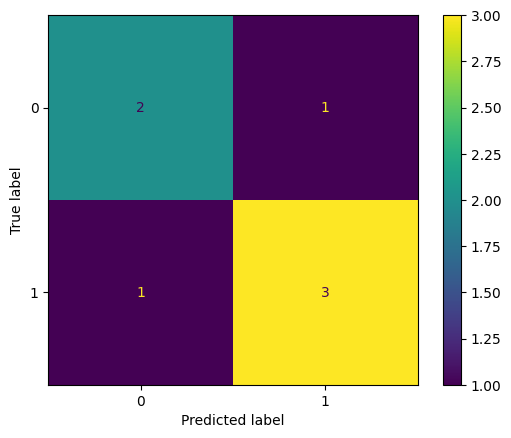

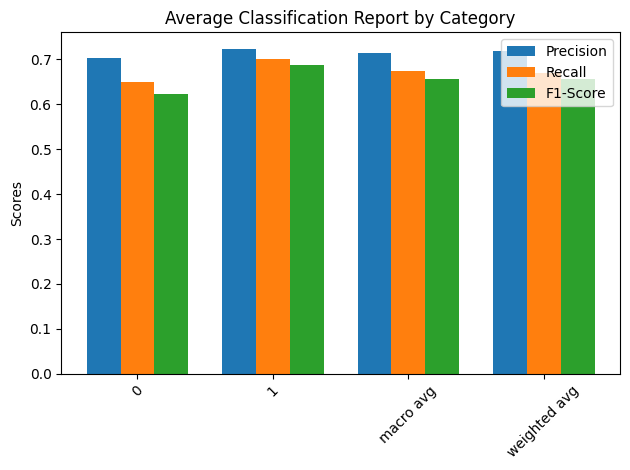

Best parameters found by GridSearchCV:  {'n_neighbors': 6}
Mean accuracy over all folds: 64.44%
Average Classification Report:
 {
    "0": {
        "precision": 0.6088888888888888,
        "recall": 0.95,
        "f1-score": 0.7331779331779331,
        "support": 4.0
    },
    "1": {
        "precision": 0.6,
        "recall": 0.37,
        "f1-score": 0.4355555555555556,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.6044444444444445,
        "recall": 0.6599999999999999,
        "f1-score": 0.5843667443667444,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.6039506172839506,
        "recall": 0.6444444444444445,
        "f1-score": 0.5775291375291374,
        "support": 8.6
    }
}


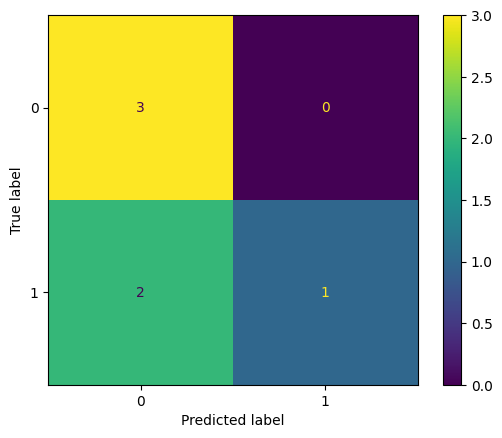

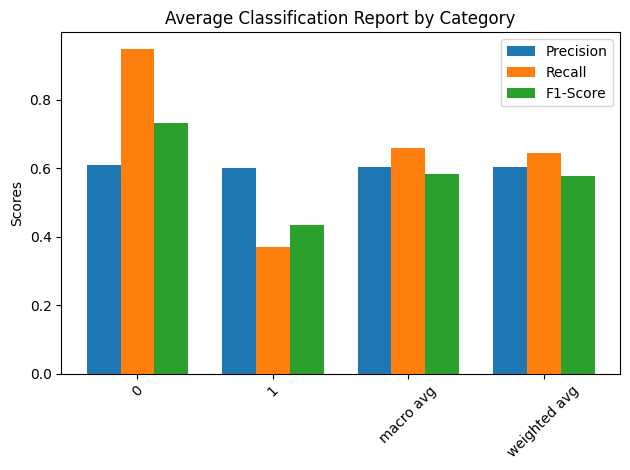

Best parameters found by GridSearchCV:  {'C': 1, 'solver': 'lbfgs'}
Mean accuracy over all folds: 69.17%
Average Classification Report:
 {
    "0": {
        "precision": 0.6866666666666666,
        "recall": 0.65,
        "f1-score": 0.6457142857142857,
        "support": 4.0
    },
    "1": {
        "precision": 0.7366666666666667,
        "recall": 0.74,
        "f1-score": 0.7184848484848485,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.7116666666666667,
        "recall": 0.6950000000000001,
        "f1-score": 0.6820995670995671,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.7151851851851851,
        "recall": 0.6916666666666667,
        "f1-score": 0.6821212121212121,
        "support": 8.6
    }
}


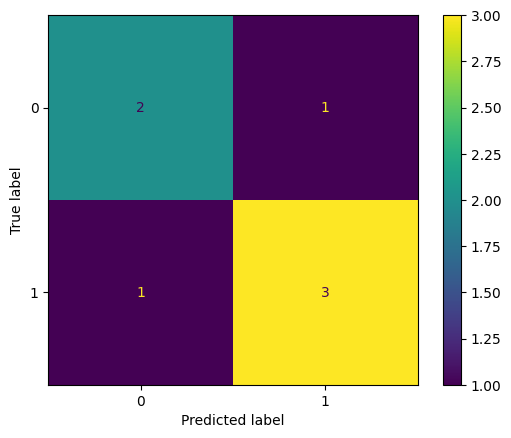

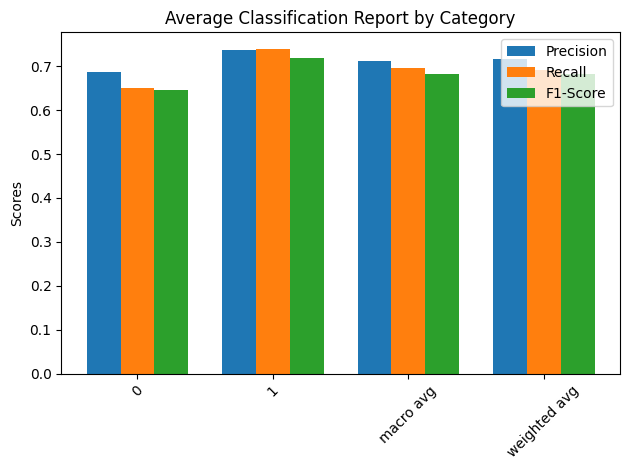

Best parameters found by GridSearchCV:  {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2}
Mean accuracy over all folds: 54.17%
Average Classification Report:
 {
    "0": {
        "precision": 0.519047619047619,
        "recall": 0.45,
        "f1-score": 0.4614718614718615,
        "support": 4.0
    },
    "1": {
        "precision": 0.5599999999999999,
        "recall": 0.63,
        "f1-score": 0.5731024531024531,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.5395238095238095,
        "recall": 0.54,
        "f1-score": 0.5172871572871574,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.544021164021164,
        "recall": 0.5416666666666666,
        "f1-score": 0.5201731601731602,
        "support": 8.6
    }
}


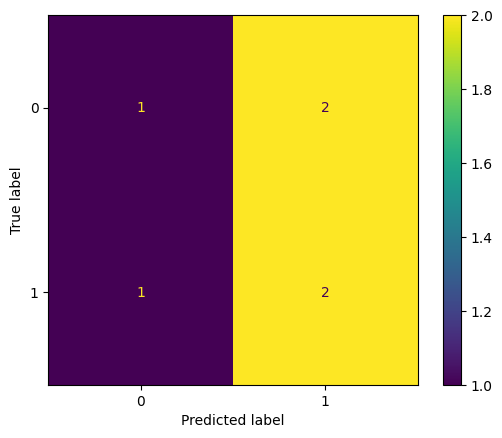

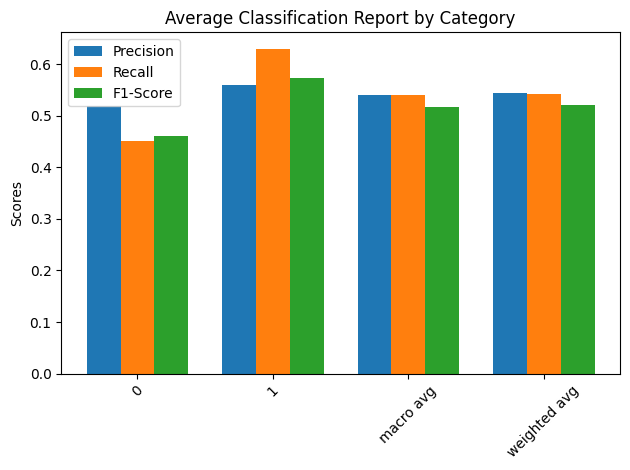

Best parameters found by GridSearchCV:  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
Mean accuracy over all folds: 65.28%
Average Classification Report:
 {
    "0": {
        "precision": 0.6333333333333333,
        "recall": 0.7,
        "f1-score": 0.6476190476190476,
        "support": 4.0
    },
    "1": {
        "precision": 0.7500000000000001,
        "recall": 0.62,
        "f1-score": 0.63,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.6916666666666667,
        "recall": 0.6599999999999999,
        "f1-score": 0.6388095238095238,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.6988888888888889,
        "recall": 0.6527777777777778,
        "f1-score": 0.6367724867724868,
        "support": 8.6
    }
}


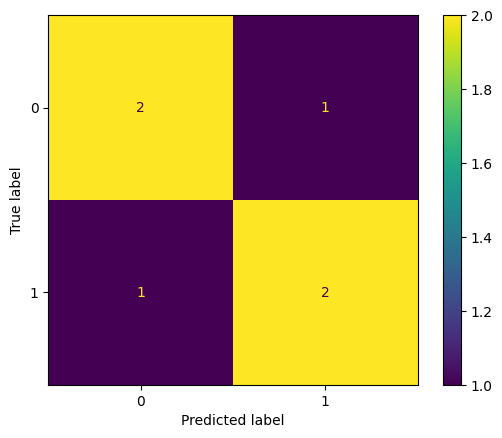

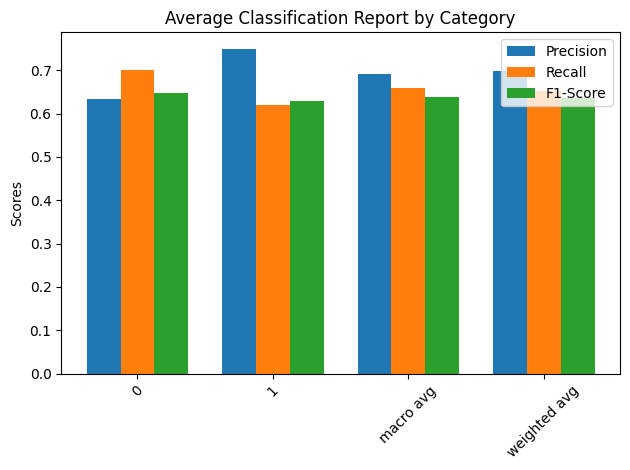

In [12]:
# Suppress all warnings
warnings.filterwarnings("ignore")

all_results = {}

param_grid = {
    "C": [0.1, 1, 10, 100],
    "kernel": ["linear", "rbf", "poly"],
    "gamma": ["scale", "auto"],
}

all_results["SVM"] = main(features, labels, param_grid, SVC)

param_grid = {"n_neighbors": np.arange(2, 10)}

all_results["KNeighborsClassifier"] = main(features, labels, param_grid, KNeighborsClassifier)

param_grid = {"C": [0.01, 0.1, 1, 10, 100], "solver": ["lbfgs", "liblinear"]}

all_results["LogisticRegression"] = main(features, labels, param_grid, LogisticRegression)

param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 10, 20, 30, 40, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

all_results["DecisionTreeClassifier"] =main(features, labels, param_grid, DecisionTreeClassifier)

# Define the model
xgb_model = xgb.XGBClassifier
xgb_model.objective='binary:logistic'

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

all_results["XGBoost"] = (
    main(features, labels, param_grid, xgb_model)
)


In [13]:
all_results

{'SVM': 66.94444444444444,
 'KNeighborsClassifier': 64.44444444444443,
 'LogisticRegression': 69.16666666666666,
 'DecisionTreeClassifier': 54.166666666666664,
 'XGBoost': 65.27777777777779}

In [14]:
# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame(list(all_results.items()), columns=['Classifier', 'Accuracy'])

# Save DataFrame to CSV file
df.to_csv('/content/ML_PCA.csv', index=False)